# Optimized based on predicted demand

## **Optimization Formulation (Single-Day Deterministic Model)**

This model determines the optimal quantity of each ingredient to purchase for a **single day**, assuming **certain demand** predicted using the `daily_sales.csv` dataset.

The goal is to **maximize profit**, considering:

* Revenue from pizzas produced
* Cost of purchasing ingredients
* Penalty for unmet demand
* Cost of spoilage for leftover ingredients

---

## **Sets**

* (P): Set of pizza SKUs
* (I): Set of ingredients

---

## **Parameters**

* $d_p$: Forecast demand for pizza (p)
* $\pi_p$: Sale price of pizza (p)
* $c_i$: Cost (USD/kg) of ingredient (i)
* $r_{p,i}$: Ingredient usage (kg) of ingredient (i) in pizza (p)
* $I_i^0$: Initial inventory of ingredient (i)
* $\alpha_p$: Penalty for unmet demand of pizza (p)
* $s_i$: Spoilage cost per kg of unused ingredient (i)
* $C$: Storage capacity

---

## **Decision Variables**

* $x_i \ge 0$: Ingredient order quantity (kg) (Integer, we can only buy in unit of kg)
* $y_p \ge 0$: Quantity of pizza (p) produced (Integer)
* $z_p \ge 0$: Unmet demand for pizza (p) (Integer)
* $w_i \ge 0$: Spoilage or leftover inventory of ingredient (i) (Continuous)

---

## **Objective Function**

$$
\max \left[
\sum_{p\in P} \pi_p y_p
-
\sum_{i\in I} c_i x_i
-
\sum_{p\in P} \alpha_p z_p
-
\sum_{i\in I} s_i w_i
\right]
$$

---


## **Constraints**

### **1. Demand Satisfaction**

$$
y_p + z_p = d_p \quad \forall p \in P
$$

### **2. Ingredient Availability**

$$
\sum_{p \in P} r_{p,i} , y_p \le I_i^0 + x_i
\quad \forall i \in I
$$

### **3. Spoilage Definition**

$$
w_i = I_i^0 + x_i - \sum_{p \in P} r_{p,i} y_p,
\qquad
w_i \ge 0
$$

### **4. Storage Capacity**

$$
\sum_{i\in I} (I_i^0 + x_i) \le C
$$


### **6. Nonnegativity**

$$
x_i, y_p, z_p, w_i \ge 0
$$

In [7]:
using CSV
using DataFrames
using LinearAlgebra
using JuMP
using Gurobi

# Load datasets
daily_sales = CSV.read("modelling data/daily_sales.csv", DataFrame)
daily_sales_predictions = CSV.read("modelling data/daily_sales_predictions.csv", DataFrame)
daily_sales_actuals = CSV.read("modelling data/daily_sales_actuals.csv", DataFrame)
ingredient_prices = CSV.read("modelling data/ingredient_prices.csv", DataFrame)
pizza_ingredient_matrix = CSV.read("modelling data/pizza_ingredient_matrix.csv", DataFrame)
pizzas = CSV.read("modelling data/pizzas.csv", DataFrame)

# Convert DataFrames to matrices if needed
daily_sales_mat = Matrix(daily_sales[:, Not(:date)])   # remove 'date' column
ingredient_prices_mat = Matrix(ingredient_prices[:, Not(:ingredient)]) # keep only prices
pizza_ingredient_matrix_mat = Matrix(pizza_ingredient_matrix[:, Not([:pizza_type_id, :pizza_name, :category])])
pizzas_mat = Matrix(pizzas[:, Not([:pizza_id, :pizza_type_id, :size])]) # only prices
;

In [8]:
# --- Sets ---
P = pizzas.pizza_id                     # pizza SKUs
I = ingredient_prices.ingredient        # ingredients

# --- Parameters ---
# Forecast demand for each pizza (single day)
d = Dict(p => daily_sales_predictions[!, p][1] for p in P)   # first row = first date

# Pizza sale price
π = Dict(p => pizzas.price[pizzas.pizza_id .== p][1] for p in P)

# Ingredient cost per kg
c = Dict(i => ingredient_prices.price_per_kg[ingredient_prices.ingredient .== i][1] for i in I)

# Ingredient usage per pizza (kg)
r = Dict()
for p in P
    pizza_type_id = pizzas.pizza_type_id[pizzas.pizza_id .== p][1]
    for i in I
        r[(p,i)] = pizza_ingredient_matrix[pizza_ingredient_matrix.pizza_type_id .== pizza_type_id, i][1]
    end
end

# Max Capacity
C = 200

# Cost per pizza produced
cost_per_pizza = Dict(p => sum(r[(p,i)] * c[i] for i in I) for p in P)

# Initial inventory
I0 = Dict(i => 0.0 for i in I)

# Penalty for unmet demand
α = Dict(p => 50.0 for p in P)

# Spoilage cost per kg of unused ingredient
s = c
;

In [13]:
# --- Model ---
model = Model(Gurobi.Optimizer)

# Decision variables
@variable(model, x[i in I] >= 0, Int)    # ingredient order quantity (kg)
@variable(model, y[p in P] >= 0, Int)    # pizza quantity produced
@variable(model, z[p in P] >= 0)    # unmet demand
@variable(model, w[i in I] >= 0)        # leftover ingredient

# --- Objective: maximize profit ---
@objective(model, Max,
    sum(π[p]*y[p] for p in P) -
    sum(c[i]*x[i] for i in I) -
    sum(α[p]*z[p] for p in P) -
    sum(s[i]*w[i] for i in I)
)

# --- Constraints ---
# Demand satisfaction
@constraint(model, [p in P], y[p] + z[p] == d[p])

# Ingredient availability
@constraint(model, [i in I], sum(r[(p,i)]*y[p] for p in P) <= I0[i] + x[i])

# Spoilage definition
@constraint(model, [i in I], w[i] == I0[i] + x[i] - sum(r[(p,i)]*y[p] for p in P))

# Capacity constraint
@constraint(model, sum(x[i] for i in I)  + sum(I0[i] for i in I) <= C)


# Solve
optimize!(model)

# Extract results
x_opt = Dict(i => value(x[i]) for i in I)
y_opt = Dict(p => value(y[p]) for p in P)
w_opt = Dict(i => value(w[i]) for i in I)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-08-20
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 229 rows, 324 columns and 1776 nonzeros
Model fingerprint: 0x90f8a355
Variable types: 162 continuous, 162 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective -2250.000000
Presolve removed 186 rows and 241 columns
Presolve time: 0.00s
Presolved: 43 rows, 83 columns, 318 nonzeros
Variable types: 0 continuous, 83 integer (55 binary)

Root relaxation: objective -3.443667e+01, 9 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incum

Dict{String31, Float64} with 66 entries:
  "Bacon"                      => 0.65
  "Goat Cheese"                => 0.79
  "Ricotta Cheese"             => 0.24
  "Sliced Ham"                 => 0.8
  "Smoked Gouda Cheese"        => 0.0
  "Jalapeno Peppers"           => 0.18
  "Prosciutto"                 => 0.0
  "Chicken"                    => 0.27
  "Oregano"                    => 0.72
  "Friggitello Peppers"        => 0.0
  "Barbecue Sauce"             => 0.56
  "Green Olives"               => 0.41
  "Capocollo"                  => 0.18
  "Zucchini"                   => 0.45
  "Italian Sausage"            => 0.91
  "Calabrese Salami"           => 0.9
  "Onions"                     => 0.92
  "Sun-dried Tomatoes"         => 0.74
  "Parmigiano Reggiano Cheese" => 0.68
  ⋮                            => ⋮

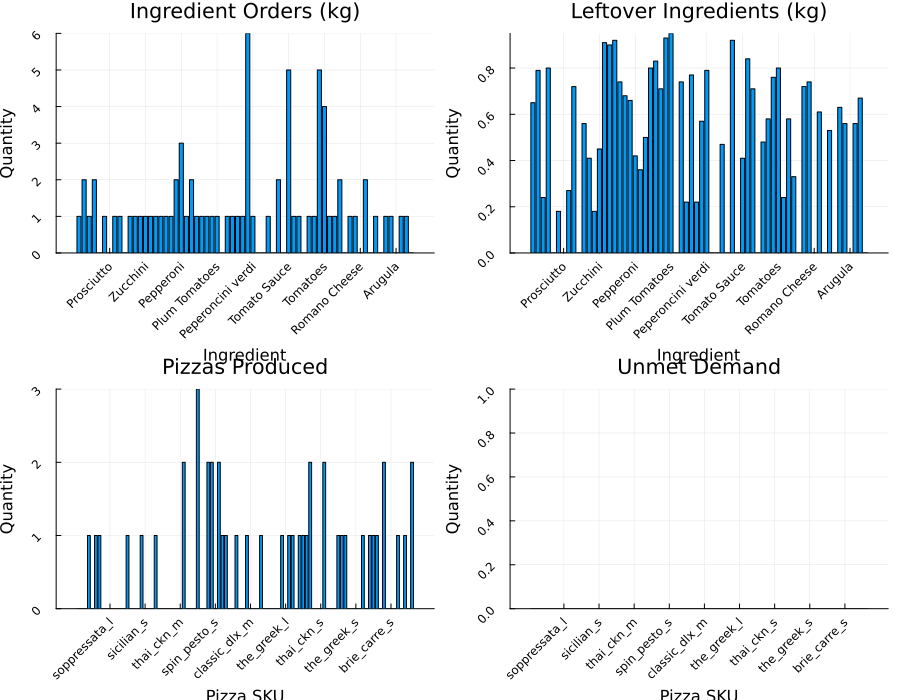

In [14]:
using Plots

ingredient_names = collect(keys(x_opt))
ingredient_orders = collect(values(x_opt))
leftover_quantities = collect(values(w_opt))

pizza_names = collect(keys(y_opt))
pizza_quantities = collect(values(y_opt))

# Create a 2x2 grid of plots
plot(layout=(2,2), size=(900,700))

# 1. Ingredient orders
plot!(ingredient_names, ingredient_orders, seriestype=:bar, title="Ingredient Orders (kg)",
      xlabel="Ingredient", ylabel="Quantity", rotation=45, legend=false, subplot=1)

# 2. Leftover ingredients
plot!(ingredient_names, leftover_quantities, seriestype=:bar, title="Leftover Ingredients (kg)",
      xlabel="Ingredient", ylabel="Quantity", rotation=45, legend=false, subplot=2)

# 3. Pizzas produced
plot!(pizza_names, pizza_quantities, seriestype=:bar, title="Pizzas Produced",
      xlabel="Pizza SKU", ylabel="Quantity", rotation=45, legend=false, subplot=3)

# 4. Unmet demand
z_opt = Dict(p => value(z[p]) for p in P)
unmet_quantities = collect(values(z_opt))
plot!(pizza_names, unmet_quantities, seriestype=:bar, title="Unmet Demand",
      xlabel="Pizza SKU", ylabel="Quantity", rotation=45, legend=false, subplot=4)


# Evaluate solution with realized demand

In [15]:
d = Dict(p => daily_sales_actuals[!, p][1] for p in P)   # first row = first date

# Use optimal values for ingredient orders
x = deepcopy(x_opt)

# --- Model ---
model2 = Model(Gurobi.Optimizer)

# Decision variables
#@variable(model2, x[i in I] >= 0, Int)    # ingredient order quantity (kg) NO LONGER A VARIABLE
@variable(model2, y[p in P] >= 0, Int)    # pizza quantity produced
@variable(model2, z[p in P] >= 0, Int)    # unmet demand
@variable(model2, w[i in I] >= 0)        # leftover ingredient

# --- Objective: maximize profit ---
@objective(model2, Max,
    sum(π[p]*y[p] for p in P) -
    sum(c[i]*x[i] for i in I) -
    sum(α[p]*z[p] for p in P) -
    sum(s[i]*w[i] for i in I)
)

# --- Constraints ---
# Demand satisfaction
@constraint(model2, [p in P], y[p] + z[p] == d[p])

# Ingredient availability
@constraint(model2, [i in I], sum(r[(p,i)]*y[p] for p in P) <= I0[i] + x[i])

# Spoilage definition
@constraint(model2, [i in I], w[i] == I0[i] + x[i] - sum(r[(p,i)]*y[p] for p in P))

# Capacity constraint
@constraint(model2, sum(x[i] for i in I)  + sum(I0[i] for i in I) <= C)

# Solve
optimize!(model2)

# Extract results
x_opt = Dict(i => value(x[i]) for i in I)
y_opt = Dict(p => value(y[p]) for p in P)
w_opt = Dict(i => value(w[i]) for i in I)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-08-20
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 229 rows, 258 columns and 1578 nonzeros
Model fingerprint: 0x7601836c
Variable types: 66 continuous, 192 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective -3408.800000
Presolve removed 229 rows and 258 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 10 available processors)

Solution count 3: -119.634 -119.634 -3408.8 
No other solutions better than -119.634

Optimal solution found (tolerance 1.00e-04)
Best obje

Dict{String31, Float64} with 66 entries:
  "Bacon"                      => 0.65
  "Goat Cheese"                => 0.79
  "Ricotta Cheese"             => 0.24
  "Sliced Ham"                 => 0.8
  "Smoked Gouda Cheese"        => 0.0
  "Jalapeno Peppers"           => 0.18
  "Prosciutto"                 => 0.0
  "Chicken"                    => 0.27
  "Oregano"                    => 0.72
  "Friggitello Peppers"        => 0.0
  "Barbecue Sauce"             => 0.56
  "Green Olives"               => 0.41
  "Capocollo"                  => 0.18
  "Zucchini"                   => 0.45
  "Italian Sausage"            => 0.91
  "Calabrese Salami"           => 0.9
  "Onions"                     => 0.92
  "Sun-dried Tomatoes"         => 0.74
  "Parmigiano Reggiano Cheese" => 0.68
  ⋮                            => ⋮

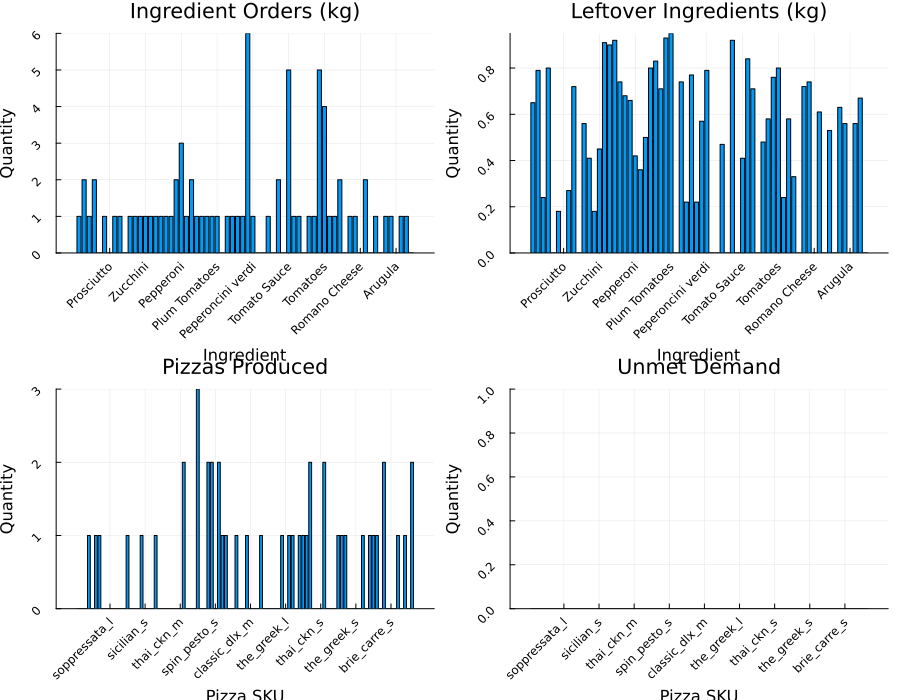

In [16]:
using Plots

ingredient_names = collect(keys(x_opt))
ingredient_orders = collect(values(x_opt))
leftover_quantities = collect(values(w_opt))

pizza_names = collect(keys(y_opt))
pizza_quantities = collect(values(y_opt))

# Create a 2x2 grid of plots
plot(layout=(2,2), size=(900,700))

# 1. Ingredient orders
plot!(ingredient_names, ingredient_orders, seriestype=:bar, title="Ingredient Orders (kg)",
      xlabel="Ingredient", ylabel="Quantity", rotation=45, legend=false, subplot=1)

# 2. Leftover ingredients
plot!(ingredient_names, leftover_quantities, seriestype=:bar, title="Leftover Ingredients (kg)",
      xlabel="Ingredient", ylabel="Quantity", rotation=45, legend=false, subplot=2)

# 3. Pizzas produced
plot!(pizza_names, pizza_quantities, seriestype=:bar, title="Pizzas Produced",
      xlabel="Pizza SKU", ylabel="Quantity", rotation=45, legend=false, subplot=3)

# 4. Unmet demand
z_opt = Dict(p => value(z[p]) for p in P)
unmet_quantities = collect(values(z_opt))
plot!(pizza_names, unmet_quantities, seriestype=:bar, title="Unmet Demand",
      xlabel="Pizza SKU", ylabel="Quantity", rotation=45, legend=false, subplot=4)
